This notebook shows classification of artist based on artwork dataset. The model is tested on few images and saved in .h5 file. 

In [1]:
#mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import *
import keras.utils as image

np.random.seed(45)
tf.random.set_seed(45)

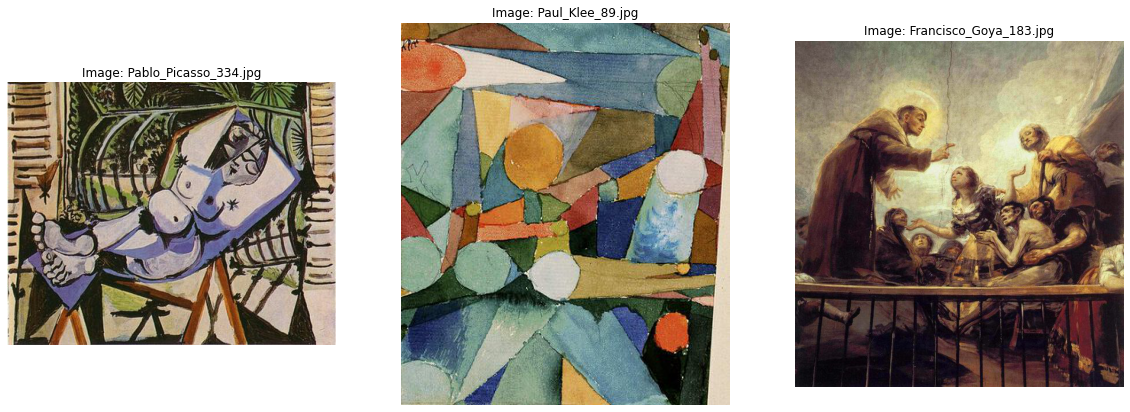

In [3]:
#Displaying few artworks

images_dir = '/content/drive/My Drive/input/resized/resized'
artists_dirs = list(set([" ".join(filename.split("_")[:-1]) for filename in os.listdir(images_dir)])) #get all names from /resized/resized
n_classes = len(artists_dirs)

fig, axes = plt.subplots(1, 3, figsize=(20,10))

for i in range(3):
    random_image = random.choice(os.listdir(os.path.join(images_dir)))
    random_image_file = os.path.join(images_dir, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Image: " + random_image)
    axes[i].axis('off')

plt.show()

In [4]:
artist_dir = list(os.listdir('/content/drive/My Drive/input/images/images'))
image_dir = '/content/drive/My Drive/input/images/images'

batch_size = 16
train_input_shape = (224, 224, 3)

In [5]:
#Data Augmentation
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   shear_range=5,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=image_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artist_dir
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=image_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artist_dir
                                                   )

train_size = train_generator.n//train_generator.batch_size
valid_size = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", train_size, "and", valid_size)

Found 7050 images belonging to 51 classes.
Found 1734 images belonging to 51 classes.
Total number of batches = 440 and 108


In [6]:
#Building Model

# Pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
x = base_model.output
x = Flatten()(x)

x = Dense(512, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Dense(16, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

output = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 20

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

train = model.fit_generator(generator=train_generator, steps_per_epoch=train_size,
                              validation_data=valid_generator, validation_steps=valid_size,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=16
                             )

In [ ]:
#Saving Model
model.save('/content/drive/My Drive/input/img_class.h5')

1/1 [==============================] - 0s 242ms/step


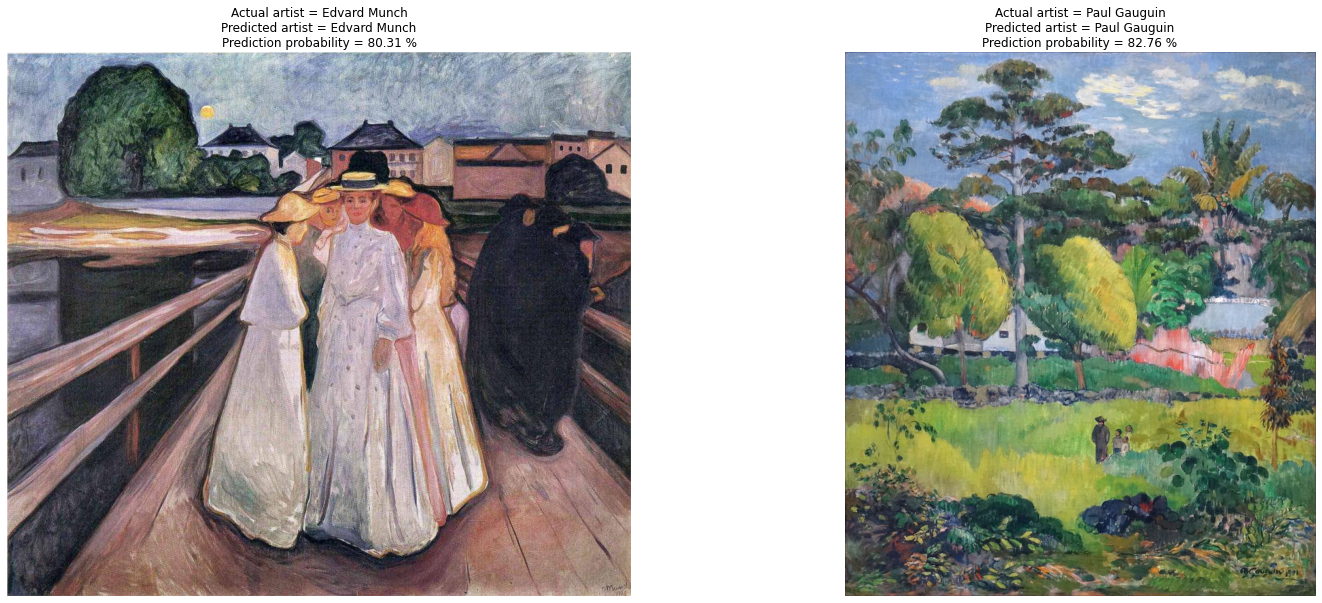

In [13]:
# Prediction
fig, axes = plt.subplots(1, 2, figsize=(25,10))

for i in range(2):
    random_artist = random.choice(artist_dir)
    random_image = random.choice(os.listdir(os.path.join(image_dir, random_artist)))
    random_image_file = os.path.join(image_dir, random_artist, random_image)

    test_image = image.load_img(random_image_file, target_size=(train_input_shape[0:2]))

    # Predict artist
    test_image = image.img_to_array(test_image)
    test_image /= 255.
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = train_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())

    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
                .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                        prediction_probability*100)

    # Print image
    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()